<a href="https://colab.research.google.com/github/JYKnomad/JYKnomad/blob/main/test_BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


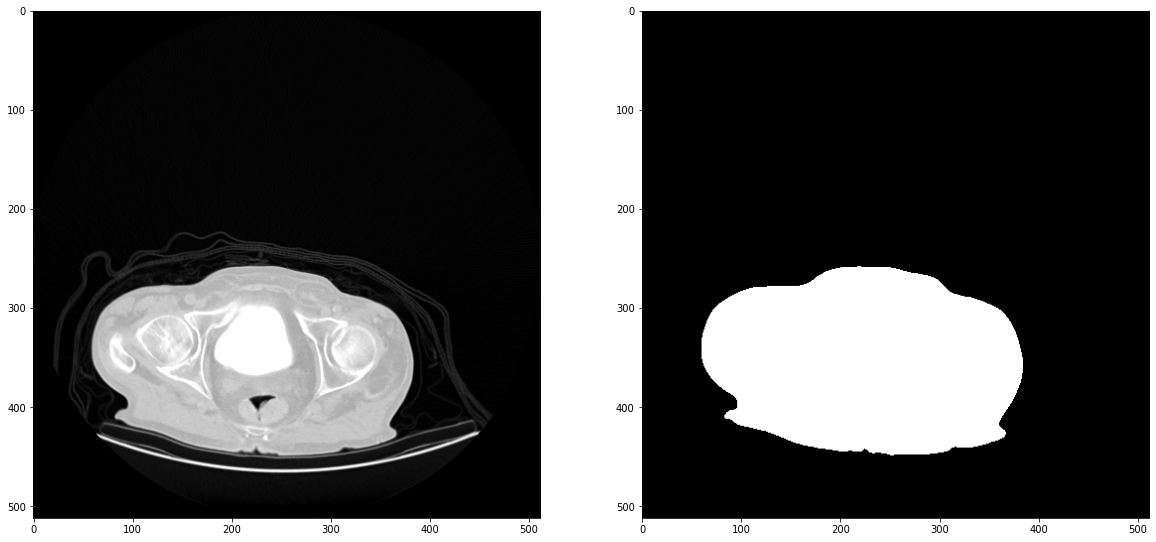

In [3]:
# =========== Segmentation_model (train01+train02)==================
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import imageio
from scipy import ndimage
from glob import glob 
import os
import os.path   
from pandas.core.common import flatten

SAMPLE = 1000

dir_path = "/content/drive/MyDrive/train_set/" 

train_im_paths = []
train_msk_paths = []

for i in range(3):
  train_path = sorted(glob(dir_path+ 'train%02d/' %int(i) +'image/*.jpg'))
  train_im_paths.append(train_path)
  mask_paths = sorted(glob(dir_path+ 'train%02d/' %int(i) +'mask/*.png'))
  train_msk_paths.append(mask_paths)

train_img_paths  = list(flatten(train_im_paths))
train_mask_paths  = list(flatten(train_msk_paths))

train_imgs = np.array([cv2.resize(cv2.imread(path, cv2.IMREAD_UNCHANGED), (512,512))
                        for path in train_img_paths])

temp = np.array([cv2.resize(cv2.imread(path, cv2.IMREAD_UNCHANGED), (512,512))
                        for path in train_mask_paths])

# ==================
train_masks = []
for elem in temp:
  temp_ = cv2.cvtColor(elem, cv2.COLOR_RGB2GRAY)
  train_masks.append(temp_)

train_masks = np.array(train_masks)
train_masks[train_masks==255] = 0.
train_masks[train_masks==15] = 0.
train_masks[train_masks==3] = 0.
train_masks[train_masks==33] = 1.

train_masks = np.reshape(train_masks, (*train_masks.shape, 1))
train_mask = train_masks.astype(np.float32)

%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[250])
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_masks[250]), cmap='gray')


In [ ]:

from PIL import Image
import numpy as np

train_reinput = train_imgs * train_masks 
train_contour = ()
for i in range(0,307): 
  train_contour = Image.fromarray(train_reinput[i])
  train_contour.save("/content/drive/MyDrive/train_set/train01/contour/" + '%03d' %int(i) +".png")
for i in range(307,576): 
  train_contour = Image.fromarray(train_reinput[i])
  train_contour.save("/content/drive/MyDrive/train_set/train02/contour/" + '%03d' for path in train_img_paths %int(i) +".png")
	
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_reinput[250])
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_masks[250]), cmap='gray')

In [4]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.models import Model


inputs = Input((512, 512, 3))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

from keras import backend as K
from keras.losses import binary_crossentropy

SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

    
from tensorflow.keras.optimizers import Adam
model.compile(Adam(learning_rate=1e-4),
              bce_dice_loss,
              metrics=[binary_crossentropy, dice_coef])
              
              
              
history = model.fit(train_imgs[50:], train_mask[50:],
          batch_size=12, epochs=10,
          validation_data=(train_imgs[:50], train_mask[:50]))

# model.save("/content/drive/MyDrive/segmentation")


Epoch 1/10
44/44 [==============================] - 143s 3s/step - loss: -0.2132 - binary_crossentropy: 0.5132 - dice_coef: 0.4715 - val_loss: -0.8615 - val_binary_crossentropy: 0.1362 - val_dice_coef: 0.9333
Epoch 2/10
44/44 [==============================] - 93s 2s/step - loss: -0.9285 - binary_crossentropy: 0.0540 - dice_coef: 0.9555 - val_loss: -0.8056 - val_binary_crossentropy: 0.1424 - val_dice_coef: 0.8874
Epoch 3/10
44/44 [==============================] - 93s 2s/step - loss: -0.9657 - binary_crossentropy: 0.0205 - dice_coef: 0.9760 - val_loss: -0.7784 - val_binary_crossentropy: 0.2023 - val_dice_coef: 0.8936
Epoch 4/10
44/44 [==============================] - 93s 2s/step - loss: -0.9831 - binary_crossentropy: 0.0097 - dice_coef: 0.9880 - val_loss: -0.7539 - val_binary_crossentropy: 0.2790 - val_dice_coef: 0.9078
Epoch 5/10
44/44 [==============================] - 93s 2s/step - loss: -0.9875 - binary_crossentropy: 0.0073 - dice_coef: 0.9912 - val_loss: -0.8646 - val_binary_cros

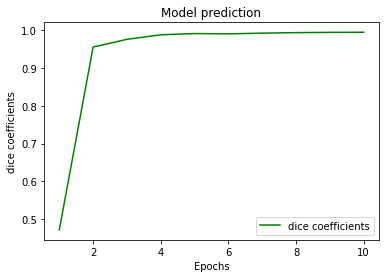

In [15]:
val_dice_coef = history.history['dice_coef']
epochs = range(1,11)
plt.plot(epochs, val_dice_coef, 'g', label='dice coefficients') 
plt.title('Model prediction')
plt.xlabel('Epochs')
plt.ylabel('dice coefficients')
plt.legend()
plt.show()

In [27]:
#라이브러리 다운로드
from PIL import Image
import glob 

#이미지 변환함수
def imgConvert(page_url,save_url):

    im = Image.open(page_url)

    im = im.convert("RGB")
    save_url_change = save_url.replace("png","jpg")
    im.save(save_url_change)
    
#함수실행 
if __name__ == "__main__":

    #변환된 파일이 저장될 폴더(jpg)
    save_url='/content/drive/MyDrive/test_set/TC_CT4/img_jpg/'
    #변환할 파일이 저장된 폴더(png)
    load_url='/content/drive/MyDrive/test_set/TC_CT4/img_png/'

    os.chdir(load_url)
    images=glob.glob('./*.png')

    images.sort()
       
    for i in range(len(images)):
        filename=images[i]
            
        save_path = save_url+images[i]
        load_path = load_url+images[i]

        imgConvert(load_path,save_path)

In [29]:
import matplotlib.pyplot as plt
from glob import glob
test_img_paths = sorted(glob('/content/drive/MyDrive/test_set/BC/img_jpg/*.jpg'))

test_imgs = np.array([cv2.resize(cv2.imread(path, cv2.IMREAD_UNCHANGED), (512,512))
                     for path in test_img_paths])

pred_img=model.predict(test_imgs)

In [75]:
np.shape(temp_pred)

(83, 512, 512, 3)

In [74]:
temp_pred = []
for elem in pred_img:
  bgr_img = cv2.cvtColor(elem, cv2.COLOR_GRAY2RGB)
  temp_pred.append(bgr_img)

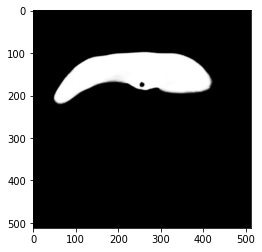

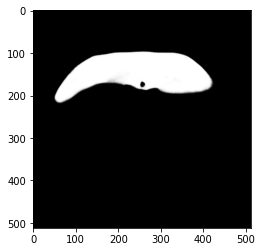

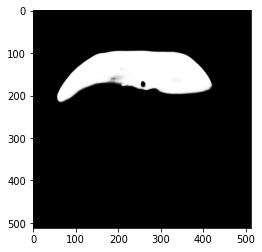

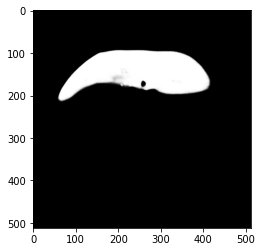

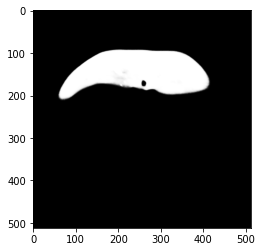

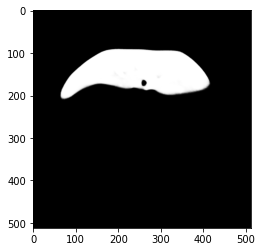

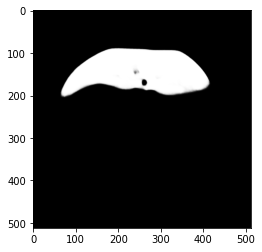

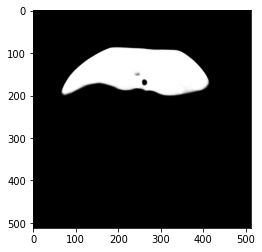

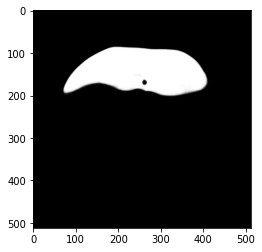

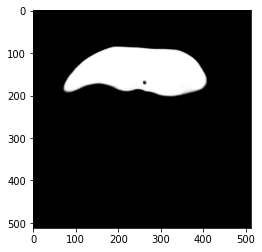

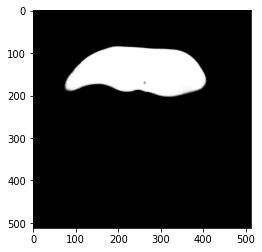

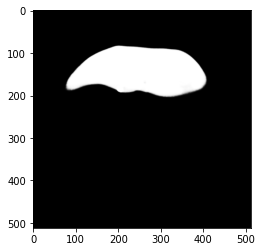

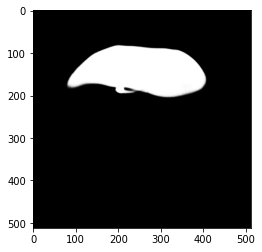

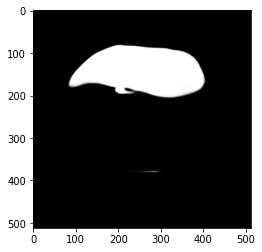

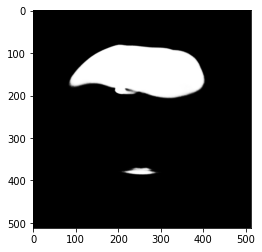

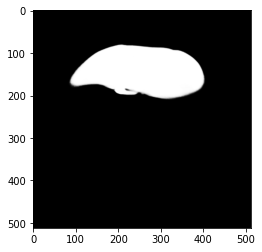

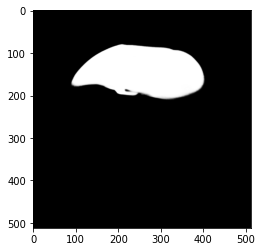

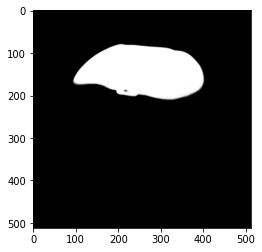

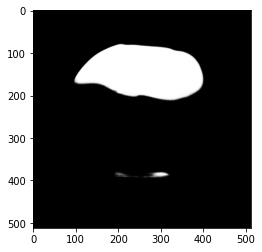

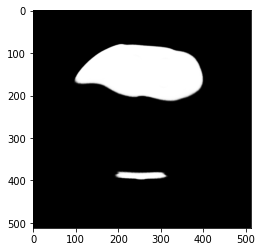

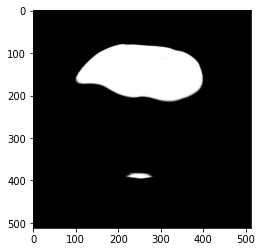

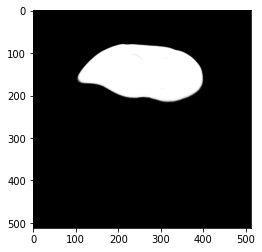

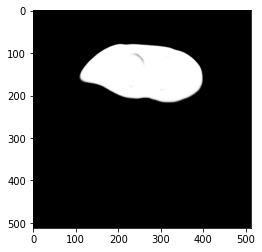

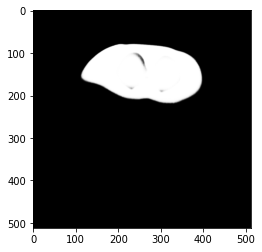

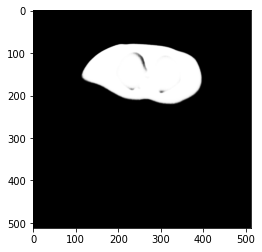

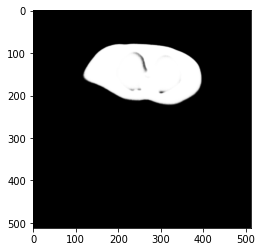

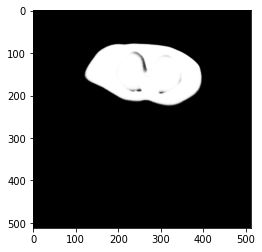

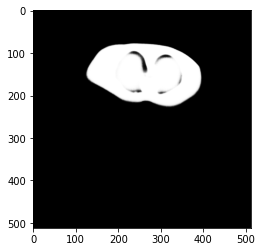

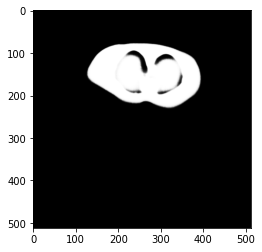

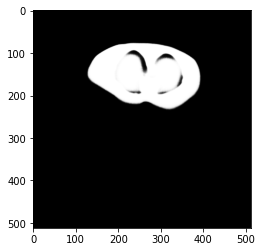

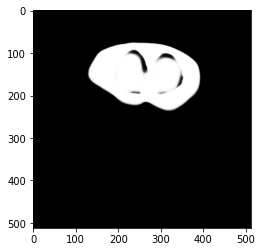

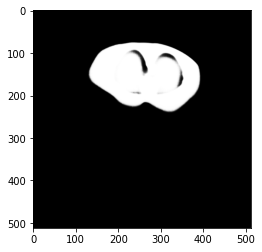

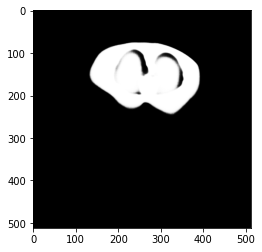

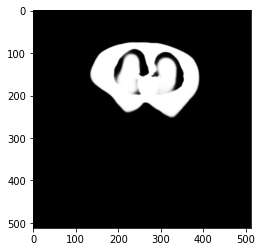

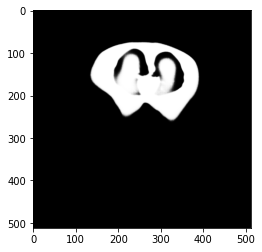

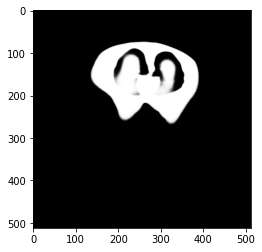

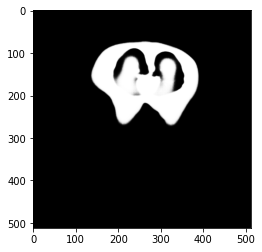

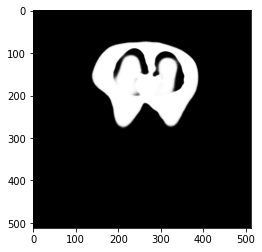

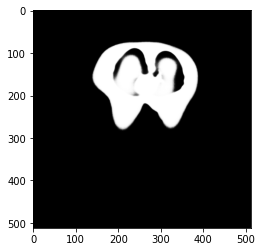

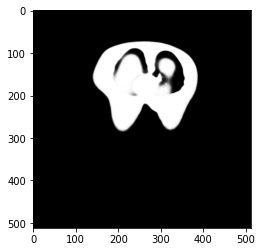

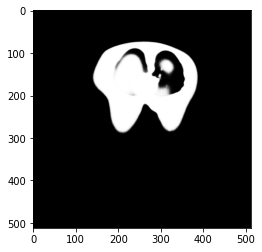

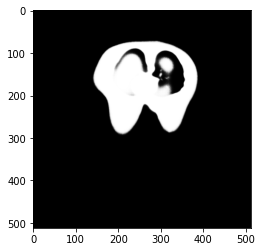

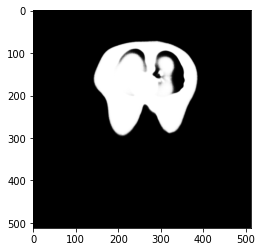

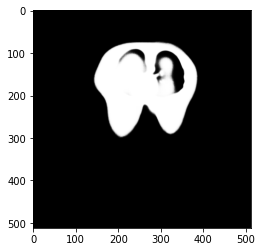

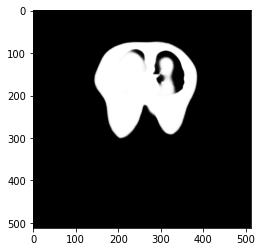

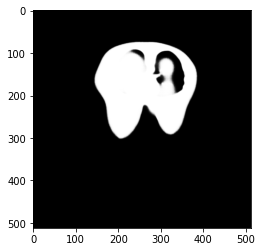

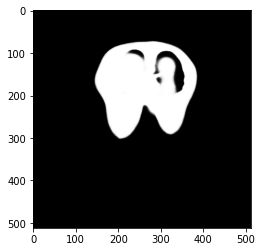

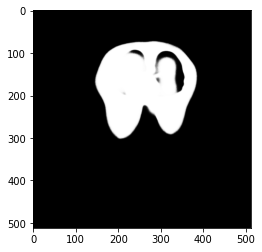

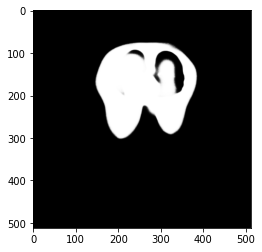

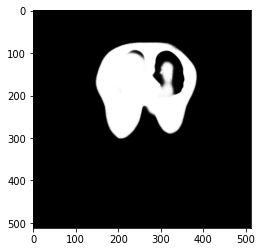

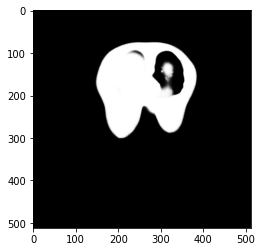

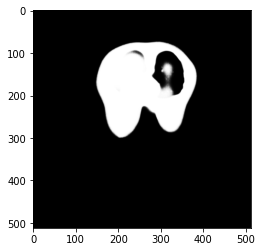

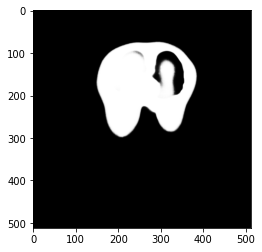

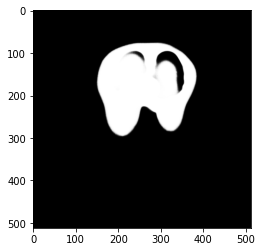

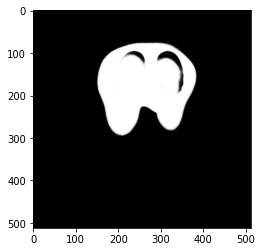

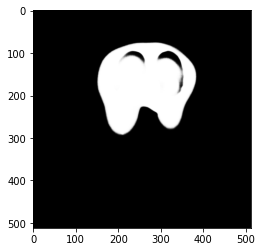

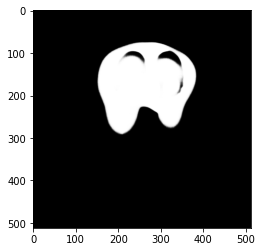

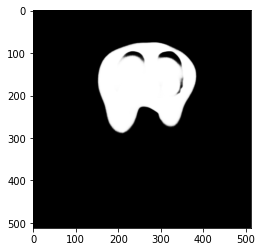

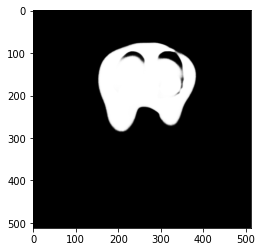

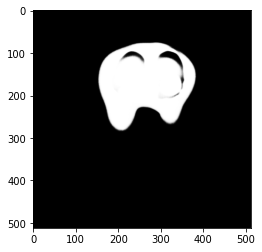

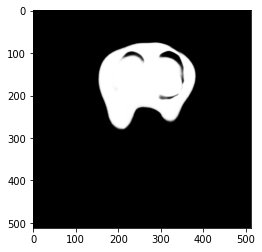

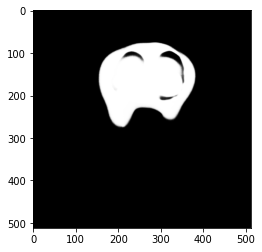

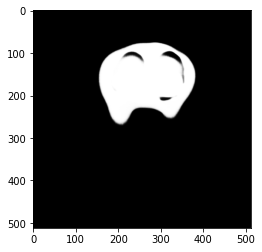

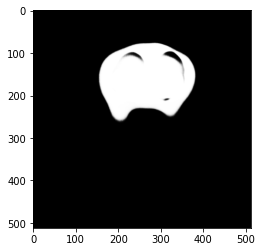

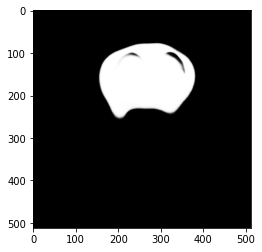

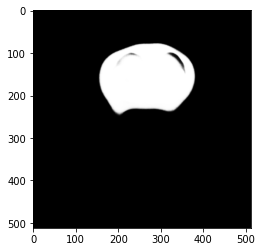

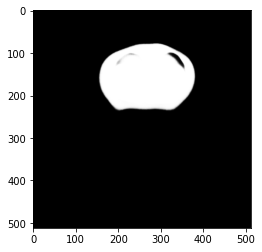

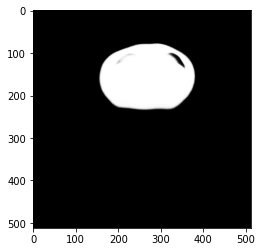

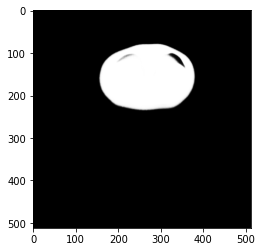

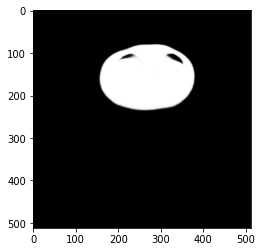

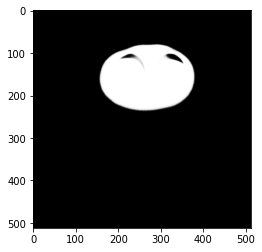

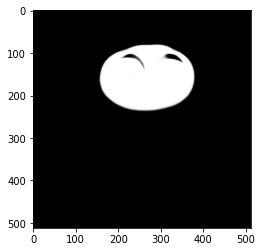

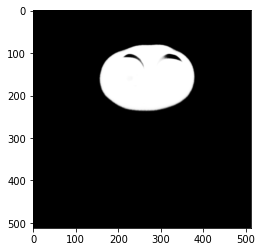

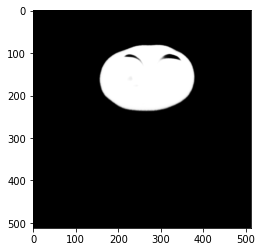

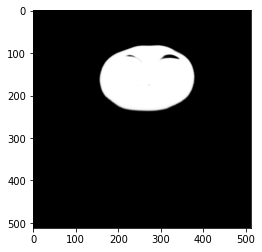

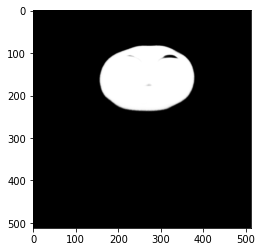

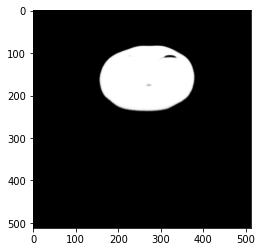

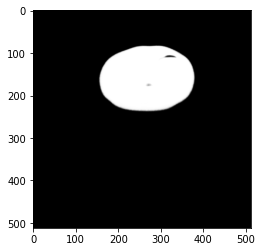

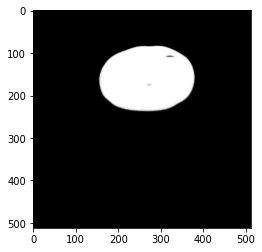

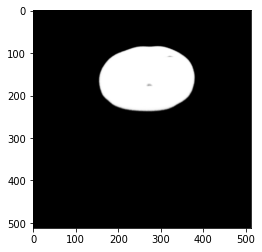

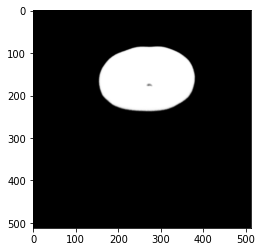

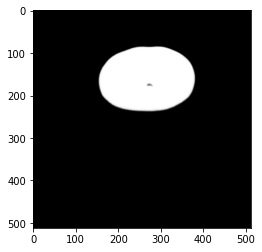

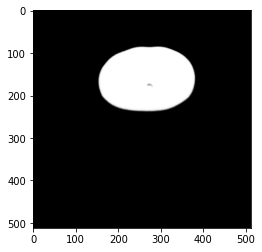

In [77]:
dst_imgs_list=[]
for img in temp_pred: 
    nor_img=cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) 
    gray_img = cv2.cvtColor(nor_img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray_img, cmap='gray')
    plt.show()

In [79]:
for i in range(len(dst_imgs_list)):
  plt.imsave('/content/drive/MyDrive/test_set/BC/result'+'1-%03d' %int(i) +".png", dst_imgs_list, cmap = 'gray')